In [1]:
from elasticsearch import Elasticsearch
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from algorithm.co_occ import BFSConstructor, CoNetwork
from algorithm.const import *
from algorithm.adapter import NetworkXAdapter, nx_draw_network

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置中文字体，并保证负号正常显示

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [2]:
es = Elasticsearch("http://127.0.0.1:9204", request_timeout=60)
dict(es.info())

{'name': 'node0',
 'cluster_name': 'docbase',
 'cluster_uuid': '63TQlJkjRvyY3NtujxmYuQ',
 'version': {'number': '8.6.1',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '180c9830da956993e59e2cd70eb32b5e383ea42c',
  'build_date': '2023-01-24T21:35:11.506992272Z',
  'build_snapshot': False,
  'lucene_version': '9.4.2',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [3]:
words_agg = {
    "top_words": {
        "terms": {
            "field": "content",
            "size": 200,
        }
    }
}
res = es.search(index=DEFAULT_INDEX, aggs=words_agg, size=0)

top_word_buckets_list = [
    bucket for bucket in
    res["aggregations"]["top_words"]["buckets"]
    if len(bucket["key"]) > 1
]

top_word_buckets_list[:5]


[{'key': '图书馆', 'doc_count': 667},
 {'key': '研究', 'doc_count': 465},
 {'key': '我国', 'doc_count': 445},
 {'key': '思考', 'doc_count': 341},
 {'key': '报道', 'doc_count': 333}]

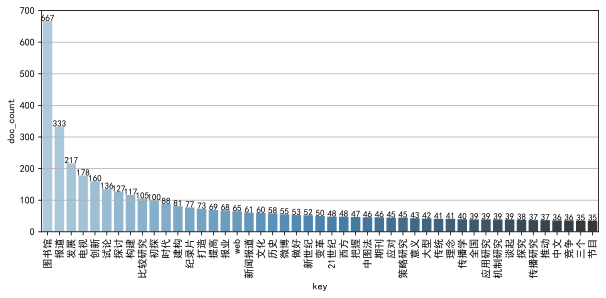

In [4]:
import matplotlib.pyplot as plt
top_word_sub_buckets = pd.DataFrame(
    bucket for i, bucket in
    enumerate( top_word_buckets_list ) 
    if i % 4 == 0
)
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=top_word_sub_buckets, 
    x="key", y="doc_count",
    palette="Blues_d",
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
)
for index,row in top_word_sub_buckets.iterrows():
#采用iterrows方法对这个dataframe进行遍历即可
    ax.text(
        index,row["doc_count"],
        row["doc_count"],
        ha="center",
        fontsize=9
        )
ax.grid(visible=True, axis="y")
plt.show()

In [5]:
queries = [
    {
        "bool": {
            "must": [
                {
                    "wildcard": {
                        DEFAULT_FIELD: f"*{bucket['key']}*"
                    },
                },
            ]
        }
    } for bucket in top_word_buckets_list
]

len(queries)

187

In [6]:
constructor = BFSConstructor(client=es)
constructor

0x18566240910 co_occ_test content

In [7]:
tests = [queries[8],queries[16],queries[30]]
print(tests)
networks = [
    constructor.get_network(query)
    for query in tests
]
print(networks)

[{'bool': {'must': [{'wildcard': {'content': '*发展*'}}]}}, {'bool': {'must': [{'wildcard': {'content': '*创新*'}}]}}, {'bool': {'must': [{'wildcard': {'content': '*网络*'}}]}}]
[nodes: 138, edges: 199, nodes: 142, edges: 248, nodes: 108, edges: 190]


In [8]:
adapted_ls = [
    NetworkXAdapter(network)
    for network in networks
]
print(adapted_ls)

[Adapter at 0x18566241100, network nodes: 138, edges: 199, Adapter at 0x18543605C10, network nodes: 142, edges: 248, Adapter at 0x18543605D60, network nodes: 108, edges: 190]


In [9]:
graphs = []
for network in adapted_ls:
    graph = nx.Graph()
    graph.add_nodes_from(network.nodes)
    graph.add_edges_from(network.edges)
    graphs.append(graph)
graphs

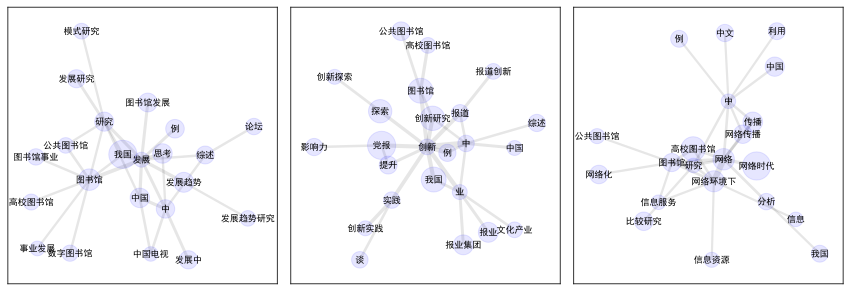

In [11]:
fig, axes = plt.subplots(1, len(graphs), figsize=(15, 5))
for i, ax in enumerate(axes):
    pos = nx.layout.spring_layout(graphs[i])
    nx_draw_network(graphs[i], pos, ax)
fig.subplots_adjust(wspace=0.05)